# Study beam impact point as a function of beam position


In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import batoid
from scipy import stats

from ghosts import tools
from ghosts import plotter
from ghosts import simulator
from ghosts import tweak_optics
from ghosts import beam
from ghosts import geom
from ghosts import reflectivity

from ghosts.analysis import compute_ghost_separations, reduce_ghosts
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_0, BEAM_CONFIG_1, BEAM_CONFIG_3, BEAM_CONFIG_4, FAST_BEAM_CONFIG_1, BASE_BEAM_SET
from ghosts.geom_configs import GEOM_CONFIG_0, GEOM_CONFIG_1, GEOM_CONFIG_2

from ghosts.camera import build_camera, show_camera

plt.rcParams['font.size']=12

In [3]:
# Some numbers from the constants module for reference
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')
print(f'Camera readout noise {LSST_CAMERA_READOUT_NOISE:d} electrons')
print(f'Camera dark current {LSST_CAMERA_DARK_CURRENT:d} electrons')
print(f'Camera noise {LSST_CAMERA_NOISE:d} electrons')
print(f'Camera pixel size {LSST_CAMERA_PIXEL_SIZE:.6f} m')

LSST Camera has 9000 pixels per mm^2
Camera readout noise 5 electrons
Camera dark current 2 electrons
Camera noise 10 electrons
Camera pixel size 0.000010 m


# Straight forward computation of the expected number of photons per pixel expected in the main spot without any filter

In [4]:
# A few numbers, sepcific to 600 nm
beam_power_600nm = 13  # 13 Watt for the full spot according to measurements done in Grenoble
ccd_reflectivity_600nm = 0.141338
ccd_qe_600nm = 0.843274
lens_reflectivity_600nm = 0.004  # 0.4% code by Julien Bolmont
filter_reflectivity_600nm = 0.038  # r band filter documentation stated transmission is 96.2%

In [5]:
# Straight forward calculation for the main spot for 100 nW
n_phot = beam.get_n_phot_for_power_nw_wl_nm(100, 600)
print(f"N photons from 100 nW at 600 nm {n_phot:e}")
n_phot_to_pixel = n_phot * (1-lens_reflectivity_600nm)**6 \
                         * (1-ccd_reflectivity_600nm) \
                         * ccd_qe_600nm * 0.9  # lens transmission, detector transmission, QE and pixels fill
print(f"N photons to pixel {n_phot_to_pixel:e}")
spot_size = (1.228)**2*math.pi
print(f"Spot size in mm2 {spot_size:.1f}")
pixel_size = 10e-3**2
print(f"Pixel size in mm2 {pixel_size:.6f}")
n_pixel_spot = spot_size/pixel_size
print(f"N pixels per spot {n_pixel_spot:e}")
n_phot_per_pixel = n_phot_to_pixel/n_pixel_spot
print(f"N photons per pixel {n_phot_per_pixel:e} for 100 nW at 600 nm")

N photons from 100 nW at 600 nm 3.020470e+11
N photons to pixel 1.921605e+11
Spot size in mm2 4.7
Pixel size in mm2 0.000100
N pixels per spot 4.737471e+04
N photons per pixel 4.056182e+06 for 100 nW at 600 nm


## conclusions
- For a 100 nW beam of 2.5 mm of diameter at 600 nm, the main spot is expected to cover 47000 pixels, with around 4 millions of photons in each pixel for a 1 s exposure.
- The full well being around 100k p.e., the main spot will be highly saturated.
- To get down to a reasonable value, we need a factor of a 100 on the flux or on the exposure: that can ben achieved by using the CCOB high speed shutter with an exposure of 10 ms.

# Now run the full CCOB simulation and analysis with the Filter

In [6]:
# adjust beam config
BEAM_CONFIG_600 = copy.deepcopy(BEAM_CONFIG_4)
BEAM_CONFIG_600['id'] = 600
BEAM_CONFIG_600['wl'] = 600e-9
BEAM_CONFIG_600['n_photons'] = 1000


Direct path is number 28
  central impact point is (-0.020672, 0.134413)
  transmission is 0.7758

Maximum expected flux is 0.7758
Maximum bin content is 360.9578


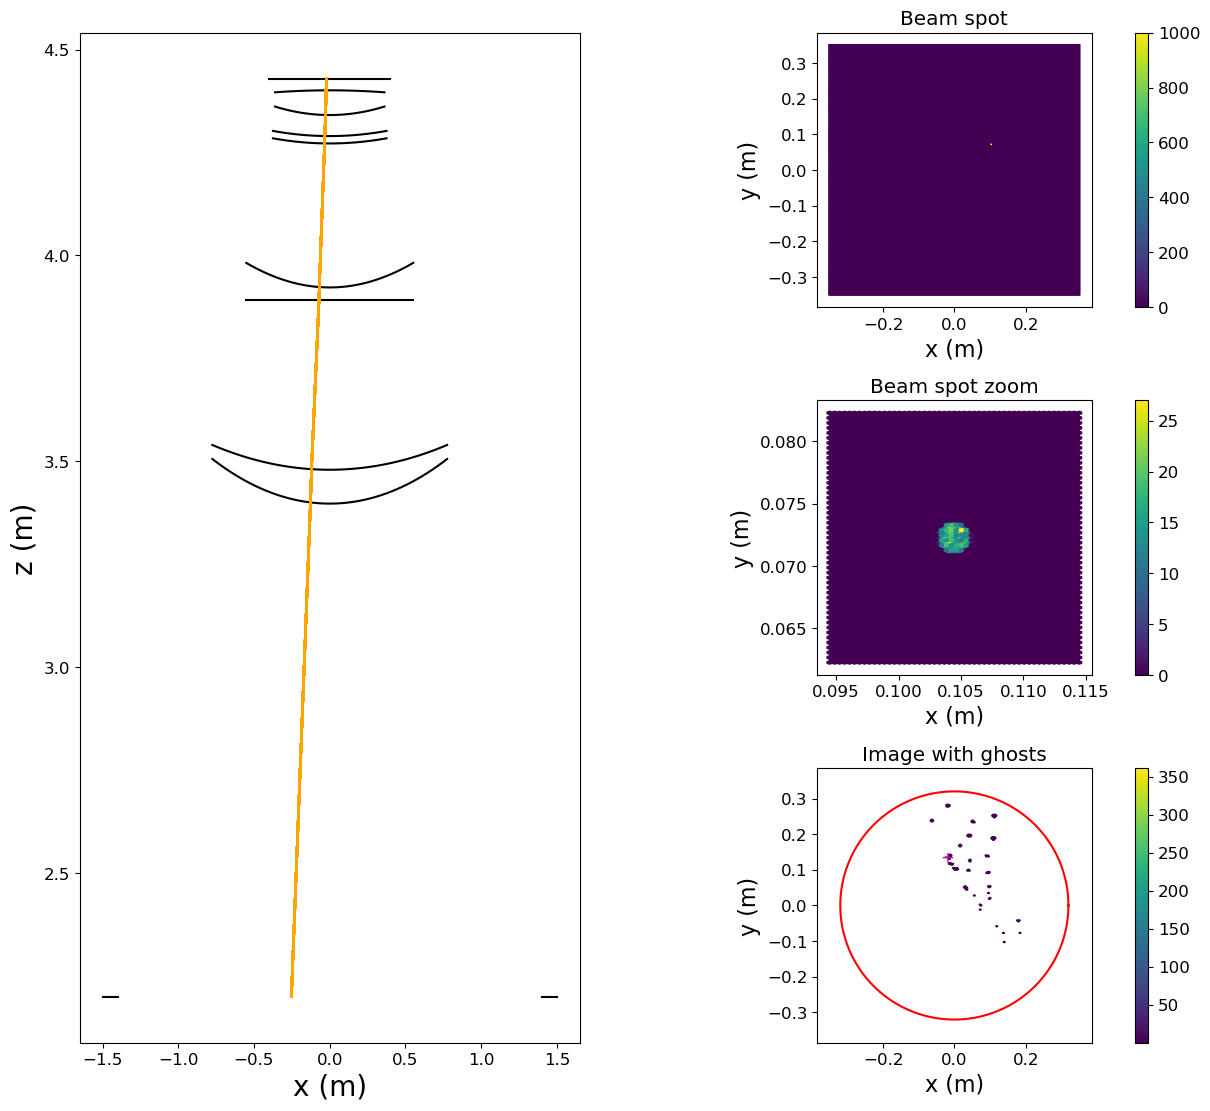

<AxesSubplot:title={'center':'Ghosts representation'}, xlabel='x (m)', ylabel='y (m)'>

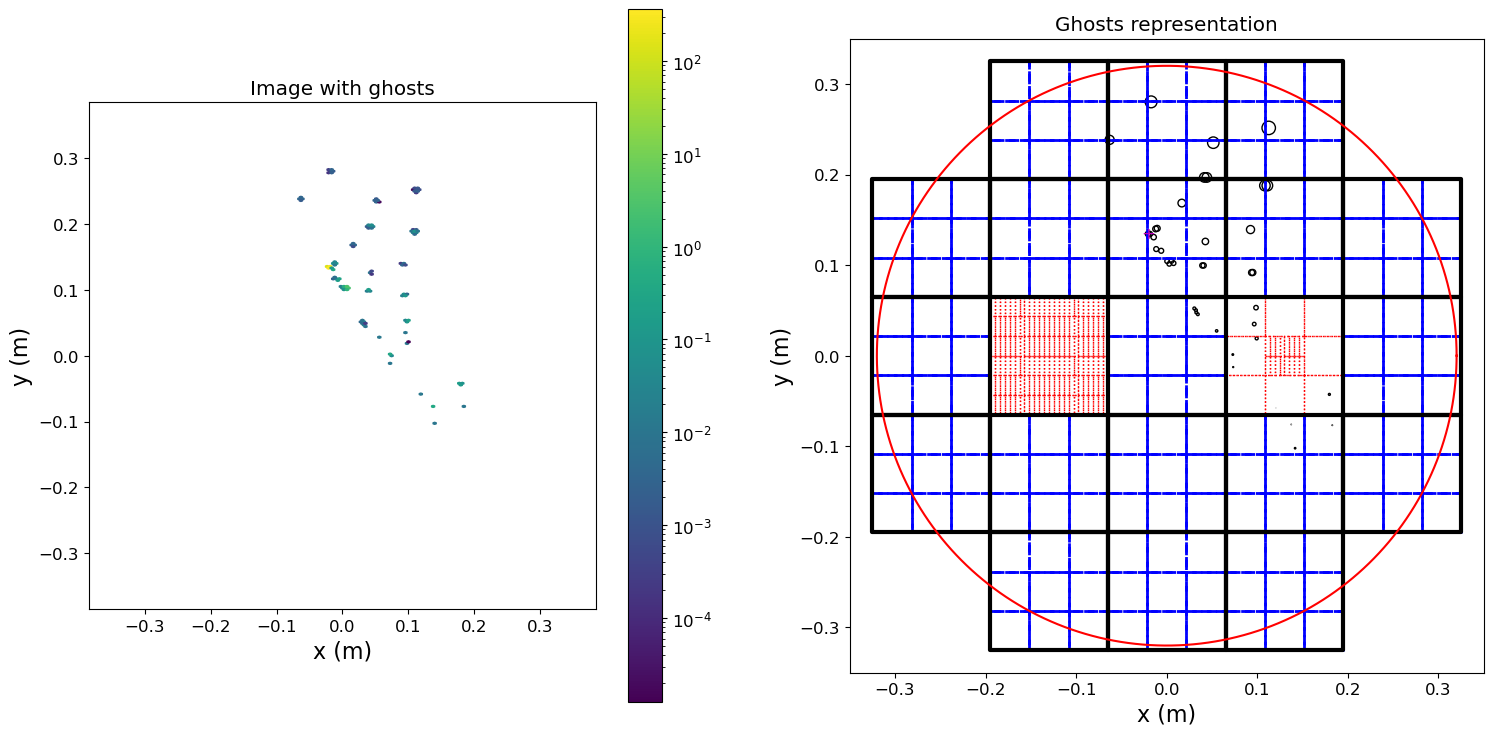

In [7]:
# Second CCOB like geometry, i.e. lenses + filters
#telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r_with_filter.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope, coating='smart',
                                    r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

# Run simulation with standard beam config
trace_full, r_forward, r_reverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_600)
simulation = [trace_full, r_forward, r_reverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)

# camera and ghosts visualization
spots_data, _spots = reduce_ghosts(r_forward)
spots_data_frame = make_data_frame(spots_data)
_fig, ax = plotter.plot_full_camera_and_spots(r_forward, spots_data_frame, log_scale=True)
camera = build_camera()
show_camera(ax[1], camera)


In [ ]:
# make figure and fill with plots
spots_data = plotter.plot_ghosts_map(r_forward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


In [ ]:
spots_data_frame.sort_values('pixel_signal', axis=0)

In [ ]:
# scaling flux
main_flux = 4.983946e+06
target_flux = main_flux/50.
print(f"Main flux / 50 = {target_flux:e}, fair enough for 10000 full well")

In [ ]:
# compute pixel signal log10
spots_data_frame["pixel_signal_log"] = np.log10(spots_data_frame["pixel_signal"])

In [ ]:
plt.rcParams["figure.figsize"] = [9, 6]
spots_data_frame.plot.bar("name", "pixel_signal_log")
plt.xlabel("Ghost")
plt.ylabel("log10(pixel_signal)")
plt.axhline(5, color="red")
plt.axhline(1, color="black")
plt.axhline(1.5, color="cyan")
plt.title("Photons per pixel in each ghost spot\nfor a 100 nW beam of diameter 2.5 mm\nat 600 nm for a 1 s exposure")

## Conclusions
- For a 100 nW beam of diameter 2.5 mm at 600 nm, and a 1 s exposure, the main spot covers 42k pixels with 4.7 millions photons per pixel.
  - As a reference, the CCOB beam power ranges from 10 nW to 100 nW depending upon the wavelength.
- The deemest ghost spot has a size of 6 mm in diameter and covers 260k pixels with just about 10 photons per pixel.
- The brightest ghost spot has a size of 0.042 mm in diameter and covers only 12 pixels with 260k photons per pixel.
- 2 ghosts spots are indeed saturated in that configuration: (Detector, L1_entrance) at almost 500k p.e./px and (L2_entrance, L1_entrance) at 260k p.e./px.
- 3 ghosts spots have a low signal: (L3_entrance, L1_exit) at 10 p.e./px, (L3_entrance, L2_entrance) and (L2_exit, L1_exit) at 15 p.e./px.
- Given this dynamic range, by dividing the exposure time by a factor of 5, i.e. 20 ms with the high speed shutter (keeping the 100 nW beam), then all ghosts spots should be above the detection threshold and not saturated.
- Note that even with a signal of just 1 p.e./px, as the deemest ghosts covers tens of thousands of pixels, it should be possible to characterize these properly. To be demonstrated though. Noise is expected to be around 10 p.e. per pixel overall.

# Study about using ghosts from throughput data for the alignment
- From numbers above, with 100 nW beam of diameter 2.5 mm at 600 nm and for a 1 s exposure, about 5e6 photons per pixel are expected.
- For the throughput data, the main spot is used and its intensity should be well within the full well, meaning that we likely want to scale the main spot density from 5e6 down to 1e5 p.e./pix (or may be lower).


In [ ]:
# Scale fluxes from the filter simulation by a factor of 50.
spots_data_frame["pixel_signal_scaled_50"] = spots_data_frame["pixel_signal"]/50.
spots_data_frame["pixel_signal_scaled_50_log"] = np.log10(spots_data_frame["pixel_signal_scaled_50"])

In [ ]:
plt.rcParams["figure.figsize"] = [9, 6]
spots_data_frame.plot.bar("name", "pixel_signal_scaled_50_log")
plt.xlabel("Ghost")
plt.ylabel("log10(pixel_signal)")
plt.axhline(5, color="red")
plt.axhline(1, color="black")
plt.axhline(1.5, color="cyan")
plt.title("Photons per pixel in each ghost spot\nfor a 100 nW beam of diameter 2.5 mm\nat 600 nm for a 20 ms exposure")

In [ ]:
# Counting number of ghosts with more than 1 p.e. of signal
n_spots_above_1pe = spots_data_frame[spots_data_frame["pixel_signal_scaled_50"]>=1]["index"].count()
print(f'{n_spots_above_1pe} ghosts spots out of 41 should have more than 1 p.e. of signal per pixel')
n_spots_above_5pe = spots_data_frame[spots_data_frame["pixel_signal_scaled_50"]>=5]["index"].count()
print(f'{n_spots_above_5pe} ghosts spots out of 41 should have more than 5 p.e. of signal per pixel')
n_spots_above_10pe = spots_data_frame[spots_data_frame["pixel_signal_scaled_50"]>=10]["index"].count()
print(f'{n_spots_above_10pe} ghosts spots out of 41 should have more than 10 p.e. of signal per pixel')

### Conclusions
- When setting the light flux so as not to saturate the main spot for the thoughput measurement, from 25% to 50% of the ghosts spots will not be detectable anymore.
- One shall also consider the presence of the filter that implies that all the ghosts spots might not be that useful and the fit convergence might be harder (but we'll have much more data).
- Another point to check is if the ghosts spots are far enough one from each other in the expected throughput beam configuration, more spots means more possible overlaps and undetectable deem spots might just add noise to other spots.
- Then, half of the throughput data, the ones that target 1 focal plane position, will be taken at a "high" angles (>10°), implying that most ghosts spots will be out of the camera.
- I need to be able to read Andy's configs to simulate a few of these to see where the ghosts are.

# Run the full simulation and analysis with no filter

In [ ]:
# Second CCOB like geometry, i.e. lenses + filters
telescope_nof = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

# Make refractive interfaces partially reflective
# Call on current telescope, smart coating is [lens, filter, camera]
tweak_optics.make_optics_reflective(telescope_nof, coating='smart',
                                    r_frac=[lens_reflectivity_600nm, filter_reflectivity_600nm, ccd_reflectivity_600nm])

# Run simulation with standard beam config
trace_full_nof, r_forward_nof, r_reverse_nof, rays_nof = simulator.run_simulation(telescope_nof, beam_config=BEAM_CONFIG_600)
simulation_nof = [trace_full_nof, r_forward_nof, r_reverse_nof, rays_nof]
# Check setup
plotter.plot_setup(telescope_nof, simulation_nof)

# camera and ghosts visualization
spots_data_nof, _spots = reduce_ghosts(r_forward_nof)
spots_data_frame_nof = make_data_frame(spots_data_nof)
_fig, ax_nof = plotter.plot_full_camera_and_spots(r_forward_nof, spots_data_frame_nof, log_scale=True)
camera_nof = build_camera()
show_camera(ax_nof[1], camera_nof)


In [ ]:
# compute pixel signal log10
spots_data_frame_nof["pixel_signal_log"] = np.log10(spots_data_frame_nof["pixel_signal"])

In [ ]:
spots_data_frame_nof.sort_values('pixel_signal', axis=0)

In [ ]:
plt.rcParams["figure.figsize"] = [9, 6]
spots_data_frame_nof.plot.bar("name", "pixel_signal_log")
plt.xlabel("Ghost")
plt.ylabel("log10(pixel_signal)")
plt.axhline(5, color="red")
plt.axhline(1, color="black")
plt.axhline(1.5, color="cyan")
plt.title("Photons per pixel in each ghost spot\nfor a 100 nW beam of diameter 2.5 mm\nat 600 nm for a 1 s exposure")

## Conclusions
- Conclusions are similar to the simulation with the filter.